# Update to hail proxy of Raupach et al 2023

In [1]:
%cd git/future_hail_global/

/home/561/tr2908/git/future_hail_global


In [2]:
import sys
sys.path.append('../aus400_hail/')
sys.path.append('../xarray_parcel/')
sys.path.append('../warming_levels/')
sys.path.append('../era5_hail_climatology/')

import dask
import json
import xarray
import warnings
import numpy as np
import pandas as pd
from importlib import reload
import modules.fut_hail as fh
import matplotlib.pyplot as plt
import modules.era5_climatol as ec
import modules.hail_sounding_functions as hs
import modules.updated_proxy as updated_proxy
import modules.parcel_functions as parcel
from dask.distributed import Client, LocalCluster

# Allow large chunks.
_ = dask.config.set(**{'array.slicing.split_large_chunks': False})

## Settings

In [3]:
plt.rcParams['figure.figsize'] = (13,5)                                   # Fig. size for non-facet plots.
plt.rcParams['font.size'] = 12                                            # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False                          # Don't use offsets in plots.
results_dir = 'results/'                                                  # Results directory.
era5_hail_cache = '~/git/aus400_hail/data/era5_hail_profiles.nc'          # ERA5 cache file for hail.
era5_storm_cache = '~/git/aus400_hail/data/era5_storm_profiles.nc'        # ERA5 cache file for other storms.
era5_nostorm_cache = '~/git/aus400_hail/data/era5_non_storm_profiles.nc'  # ERA5 cache file for no-storm cases.
lookup_dir = '/g/data/w42/tr2908/aus400_hail/'                            # Moist-adiabat lookup cache directory. 
proxy_results_file = '../aus400_hail/results/results_era5.json'           # Trained proxy definition file. 
proxy_conds_file = '~/git/aus400_hail/results/era5_proxy_extra_conds.csv' # Extra proxy conditions file.
base_dir = '/g/data/w42/tr2908/era5_hail_climatology/'                    # Base directory for proxy data.
landsea_file = f'{base_dir}/landsea_mask/landsea_mask_Australia.nc'       # Land-sea file to use.
climatol_dir = f'{base_dir}/era5/'                                        # Hail conditions climatology directory.
proxy_dir = f'{base_dir}/era5_proxy/'                                     # Hail proxy climatology directory.
proxy_nc_dir = f'{base_dir}/era5_proxy/'                                  # Hail proxy with no extra conditions climatology directory.

## Setup

In [4]:
plt.show()                                                 # Start the plotting engine.
plt.rcParams['font.size'] = 16                             # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False           # Don't use offsets in plots.
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore FutureWarnings (in Dask).

In [5]:
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:39055' processes=7 threads=28, memory=126.00 GiB>


In [6]:
parcel.load_moist_adiabat_lookups(base_dir=lookup_dir, chunks=-1)

## Load data

Open the original proxy values.

In [7]:
with open(proxy_results_file, 'r') as f:
    era5_results = json.load(f)
extra_conditions = pd.read_csv(proxy_conds_file)
band_var = era5_results['band_variable']

MLH: 200, alpha: [-1.62872], beta [0.04484252].
MLH: 1000, alpha: [-0.61272], beta [1.92171951].
MLH: 1500, alpha: [0.02228], beta [20.12287364].
MLH: 2000, alpha: [0.65728], beta [210.71235453].
MLH: 3000, alpha: [1.92728], beta [23104.15024013].
MLH: 8000, alpha: [8.27728], beta [3.66176104e+14].


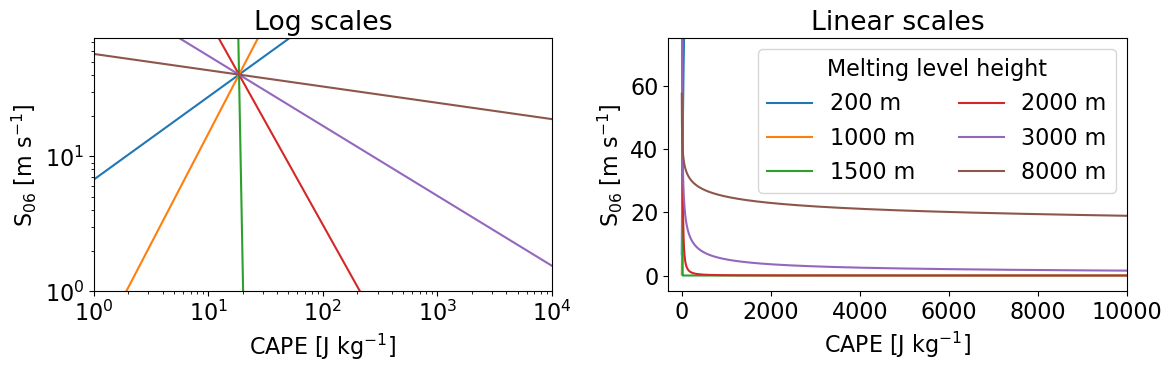

In [8]:
updated_proxy.plot_proxy_discrims(era5_results=era5_results, file='results/supplementary/proxy_by_MLH.pdf', figsize=(12,4))

When the melting level height is below about 2000 m, the discriminator line in log-log space is close to vertical meaning that only CAPE matters and shear is not required. Below about 1500 m the slope of the line is negated. We make a simple change so that below 2000 m, the proxy is fixed at the discriminator for 2000 m.

Load era5 data using cached version from proxy training.

In [9]:
hail_profiles = hs.read_era5_profiles(coords=None, cache_file=era5_hail_cache)
storm_profiles = hs.read_era5_profiles(coords=None, cache_file=era5_storm_cache)
nostorm_profiles = hs.read_era5_profiles(coords=None, cache_file=era5_nostorm_cache)

Removed 20 profiles for having distance over 25 km from requested point.
Removed 434 profiles for having distance over 25 km from requested point.
Removed 451 profiles for having distance over 25 km from requested point.


Calculate convective indices. Note that the version of the environment (eg. analysis3-22.01 vs analysis3-24.04 etc) has small effects on the values produced for convective parameters.

In [10]:
%%capture 
# Using %%capture to discard long output.
conv_hail = hs.profile_properties(profiles=hail_profiles).to_dataframe()
conv_storm = hs.profile_properties(profiles=storm_profiles).to_dataframe()
conv_nostorm = hs.profile_properties(profiles=nostorm_profiles).to_dataframe()

# Remove duplicated storms.
conv_hail = conv_hail[~conv_hail.duplicated()]
conv_storm = conv_storm[~conv_storm.duplicated()]
conv_nostorm = conv_nostorm[~conv_nostorm.duplicated()]

# Set hail flags.
conv_hail['true_hail'] = True
conv_storm['true_hail'] = False
conv_nostorm['true_hail'] = False
d = pd.concat([conv_hail, conv_storm, conv_nostorm])

In [11]:
d['new_proxy'] = updated_proxy.apply_proxy(dat=d, band_var=band_var, 
                                           alpha_a=era5_results['hail_alpha_a'],
                                           alpha_b=era5_results['hail_alpha_b'], 
                                           beta_a=era5_results['hail_beta_a'], 
                                           beta_b=era5_results['hail_beta_b'],
                                           band_limits=[2000, None])

In [12]:
d['old_proxy'] = updated_proxy.apply_proxy(dat=d, band_var=band_var, 
                                           alpha_a=era5_results['hail_alpha_a'],
                                           alpha_b=era5_results['hail_alpha_b'], 
                                           beta_a=era5_results['hail_beta_a'], 
                                           beta_b=era5_results['hail_beta_b'],
                                           band_limits=None)

Original "extra condition" thresholds from Raupach et al., 2023 were:

```
Threshold of lapse_rate_700_500 < -5.45 will remove ~2.5% of good (Hail) points but ~13.0% of bad points.
Threshold of mixed_100_lifted_index < 0.4 will remove ~2.5% of good (Hail) points but ~10.0% of bad points.
Threshold of temp_500 < 265.46 will remove ~2.5% of good (Hail) points but ~9.0% of bad points.
```

In [13]:
updated_proxy.prox_performance(dat=d.copy(), proxy='old_proxy', extra_conditions=extra_conditions)

Before extra conds:
POD: 0.75
FAR: 0.68
HSS: 0.35
SR: 0.32
bias: 2.32
CSI: 0.29

lapse_rate_700_500 < -5.45 removes 2.7% of hits and 13.0% of false positives.
mixed_100_lifted_index < 0.4 removes 2.6% of hits and 10.0% of false positives.
temp_500 < 265.46 removes 2.6% of hits and 9.0% of false positives.

After extra conds:
POD: 0.7
FAR: 0.62
HSS: 0.4
SR: 0.38
bias: 1.81
CSI: 0.33


In [14]:
updated_proxy.prox_performance(dat=d.copy(), proxy='new_proxy', extra_conditions=extra_conditions)

Before extra conds:
POD: 0.75
FAR: 0.67
HSS: 0.35
SR: 0.33
bias: 2.29
CSI: 0.3

lapse_rate_700_500 < -5.45 removes 2.7% of hits and 13.0% of false positives.
mixed_100_lifted_index < 0.4 removes 2.4% of hits and 8.0% of false positives.
temp_500 < 265.46 removes 2.6% of hits and 9.0% of false positives.

After extra conds:
POD: 0.7
FAR: 0.62
HSS: 0.4
SR: 0.38
bias: 1.81
CSI: 0.33


## Effect of change on climatology/trend 

In [15]:
%%time
climatol_all, climatol_land, nonphys_perc = updated_proxy.era5_proxies(climatol_dir=climatol_dir, landsea_file=landsea_file, 
                                                                       results_file=proxy_results_file, extra_conds_file=proxy_conds_file)

CPU times: user 2min 8s, sys: 15.4 s, total: 2min 24s
Wall time: 3min 48s


Uncomment the following cell to check that the old proxy calculation used here matches that used in Raupach et al., 2023b (npj) (it does match but the code is slow so not run every time).

In [16]:
# climatol_all_orig, climatol_land_orig, _ = ec.read_era5(climatol_dir=climatol_dir, proxy_dir=proxy_dir, 
#                                                         proxy_nc_dir=None, landsea_file=landsea_file)
# assert climatol_all.old_prox.equals(climatol_all_orig.hail_proxy), 'Old proxies do not match.'

In [17]:
prox_diff = climatol_all.new_prox != climatol_all.old_prox
percent_diff_per_pixel = (prox_diff.sum('time') / len(prox_diff.time) * 100)

In [ ]:
print(f'Over the whole ERA5 dataset used previously:')
print(f'At most, a pixel has {np.round(percent_diff_per_pixel.max().values, 2)}% of its values changed by the proxy change.')
print(f'At most over land, a pixel has {np.round(percent_diff_per_pixel.where(lsm.lsm > 0.5).max().values, 2)}% of its values changed by the proxy change.')

Over the whole ERA5 dataset used previously:


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 17.82 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
_ = fh.plot_map(percent_diff_per_pixel, figsize=(8,8))

In [ ]:
def climatol(climatol_all, v):
    d = climatol_all.sel(time=slice('1979', '2021'))
    
    def per_year(x, v):
        mask = np.logical_not(np.isnan(x[v].max('time')))
        return x[v].resample(time='1Y').sum('time').mean('time').where(mask)
            
    d = per_year(d, v)
    return d

climatol_old = climatol(climatol_all, v='old_prox').load()
climatol_new = climatol(climatol_all, v='new_prox').load()

In [ ]:
climatol_diffs = (climatol_new - climatol_old)
climatol_reldiffs = climatol_diffs / climatol_old * 100
_ = fh.plot_map([climatol_diffs, climatol_reldiffs], ncols=2, wspace=0.2, cmap='RdBu_r', divergent=True)

In [ ]:
climatol_land['old_prox'] = climatol_land.old_prox.chunk({'latitude': 20, 'longitude': 20, 'time': -1})
climatol_land['new_prox'] = climatol_land.new_prox.chunk({'latitude': 20, 'longitude': 20, 'time': -1})

In [ ]:
%%time
yearly, seasonal = ec.calc_all_trends(dat=climatol_land, norm_variables=['old_prox', 'new_prox'], 
                                      norm_units={'new_prox': 'days',
                                                  'old_prox': 'days'},
                                      q_variables={}, do_seasonal=False, no_cache=True)

In [ ]:
_ = fh.plot_map([yearly['old_prox'].slope, yearly['new_prox'].slope], ncols=2, cmap='RdBu_r', divergent=True, share_scale=True, share_axes=True)

In [ ]:
diffs = yearly['new_prox'].slope - yearly['old_prox'].slope
reldiffs = diffs / yearly['old_prox'].slope
_ = fh.plot_map([diffs, reldiffs], ncols=2, cmap='RdBu_r', divergent=True)